### Human In The Loooop (Human Interaction)...

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="groq:llama-3.3-70b-versatile")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000244ED5E3860>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000244EE051FA0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [5]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langgraph.types import Command, interrupt

In [6]:
## Initialize The StateGraph
graph_builder = StateGraph(State)

In [7]:
## Create a Custom Human Assistance Tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [8]:
## Tavily Search Tool

tavily_search = TavilySearch(max_results=2)

In [9]:
## Combine the tools into a list
tools = [human_assistance, tavily_search]

In [10]:
## Combine These Tools with LLM
llm_with_tools = llm.bind_tools(tools=tools)

In [11]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    return { "messages": [message] }

In [12]:
## Add The Required Nodes to the Graph
graph_builder.add_node("SuperChatBot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [13]:
## Add The Required Edges to the Graph
graph_builder.add_conditional_edges(
    "SuperChatBot",
    tools_condition
)

graph_builder.add_edge("tools", "SuperChatBot")

graph_builder.add_edge(START, "SuperChatBot")

In [14]:
## Initialize the memory saver
memory = MemorySaver()

In [15]:
## Compile the graph with memory saver
graph = graph_builder.compile(checkpointer=memory)

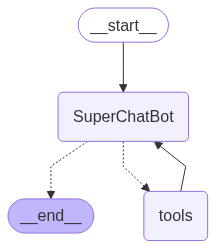

In [16]:
## Display the graph in Mermaid format

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
user_input = "I need some expert Roadmap for building an AI agent. Could you request assistance for me?"

config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert Roadmap for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (a7wafxary)
 Call ID: a7wafxary
  Args:
    query: Need expert roadmap for building an AI agent


In [18]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"

config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (qn8tbvh5r)
 Call ID: qn8tbvh5r
  Args:
    query: building an AI agent guidance and assistance


In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (qn8tbvh5r)
 Call ID: qn8tbvh5r
  Args:
    query: building an AI agent guidance and assistance
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (cfh1gqkzs)
 Call ID: cfh1gqkzs
  Args:
    query: LangGraph and autonomous agent comparison
